# Fitting

In [22]:
%matplotlib qt
import matplotlib.pyplot as plt
from pyhdx import PeptideMasterTable, read_dynamx, KineticsFitting
from pathlib import Path
import numpy as np

In [21]:
import pyhdx
print(pyhdx.__file__)
pyhdx.__git_sha__

C:\Users\jhsmi\pp\PyHDX\pyhdx\__init__.py


'2f1502d'

We load the sample SecB dataset, apply the control, and split the dataset into ``KineticSeries``.

In [2]:
fpath = Path() / '..' / '..' / 'tests' / 'test_data' / 'ecSecB_apo.csv'
data = read_dynamx(fpath)
master_table = PeptideMasterTable(data, drop_first=1, ignore_prolines=True)
master_table.set_control(('Full deuteration control', 0.167))
states = master_table.groupby_state()
series = states['SecB WT apo']
series.make_uniform()

From this ``KineticsSeries`` object we can make a ``KineticsFitting`` object. The ``bounds`` parameter defines the upper
and lower limit of the kinetic rates which are fitted. Temperature (in Kelvin) and pH of the D-labelling step are used to
calculate the intrinsic D-exchange rate. 

In [3]:
kf = KineticsFitting(series, bounds=(1e-2, 300), temperature=303.15, pH=8.)

We can now start the first step of fitting, by weighted averaging. The ``RuntimeWarning`` messages are normal and can be ignored.

In [4]:
result_wt_avg = kf.weighted_avg_fit()

C:\Users\jhsmi\Miniconda3\envs\py37_panel_dev\lib\site-packages\symfit\core\objectives.py:321: RuntimeWarning: overflow encountered in square
  (dep_var_value - dep_data) ** 2 / sigma ** 2
<string>:2: RuntimeWarning: overflow encountered in exp
C:\Users\jhsmi\Miniconda3\envs\py37_panel_dev\lib\site-packages\scipy\optimize\optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
C:\Users\jhsmi\Miniconda3\envs\py37_panel_dev\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: overflow encountered in exp
<string>:2: RuntimeWarning: invalid value encountered in subtract


The return value is a ``KineticsFitResult`` object. This object has a list of models, intervals in withing the protein 
sequence to which these models apply, and their corresponding ``symfit`` fit result with parameter values. The effective 
exchange rate can be extracted, as well as other fit parameters, from this object:

In [25]:
output = result_wt_avg.output
output.dtype.names

('r_number', 'rate', 'k1', 'k2', 'r')

In [26]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(output['r_number'], output['rate'])
ax.set_xlabel('Residue number')
ax.set_ylabel('Rate (min⁻¹)')
None

We can now use the weighted averaging fitted result as initial guesses for the global fitting step. This returns a
``TFFitResult`` object, which has only one interval and model.

In [7]:
result_global = kf.global_fit(output)


We can obtain protection factors and ΔG values from the result. The protection factors are in log (base 10) format.

In [10]:
tf_output = result_global.output
print(tf_output.dtype.names)
deltaG = 8.3*303.15*(tf_output['log_P'] / np.log10(np.e))

('r_number', 'log_P_full', 'log_P')


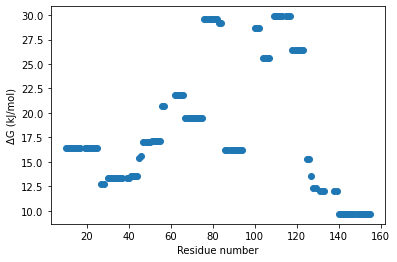

In [13]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.scatter(tf_output['r_number'], deltaG*1e-3)
ax.set_xlabel('Residue number')
ax.set_ylabel('ΔG (kJ/mol)')
None


